In [1]:
#coding utf8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import tensorflow as tf
import keras_tuner as kt
from scipy.io import loadmat
from tensorflow import keras
from tensorflow.keras import layers, metrics
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import svm
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.feature_selection import mutual_info_regression, f_regression, r_regression
import sklearn
from mpl_toolkits.mplot3d import Axes3D
#from PyIF import te_compute as te
#from neuralprophet import NeuralProphet

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [171]:
'''
Functions for loading in and combining data
'''

def load_df(file_name, sheet = 'Sheet 1'):
    '''
    Load a file into a data frame that is quarterly from the Eurostat website
    '''
    df = pd.read_excel(file_name, sheet_name=sheet)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df.replace(':', np.nan, inplace=True)
    df.index = df.iloc[:, 0]
    df.drop(df.columns[[0]], axis=1, inplace=True)
    for i in df.columns[:]:
        df[i] = df[i].apply(pd.to_numeric, errors="coerce")
    df.interpolate(method='linear', inplace=True, axis = 1)
    df.sort_index(inplace=True)
    df = df.rename({'Germany (until 1990 former territory of the FRG)': 'Germany'})
    return df

def create_per_employeer(GDP_df, HW_df, employees_df):
    ''' 
    Inputs: GDP, hours worked, and employees dataframes
    Output: dataframe with per-employee GDP and per hour worked GDP
    '''
    cols =(list(set(GDP_df.columns) and set(employees_df.columns) and set(HW_df.columns)))
    cols.sort()
    idx = cols.pop()
    per_employee_df = pd.DataFrame(index=GDP_df.index, columns=cols)
    per_HW_df = pd.DataFrame(index=GDP_df.index, columns=cols)
    for i in cols:
        per_employee_df[i] = GDP_df[i]/employees_df[i]
        per_HW_df[i] = per_employee_df[i]/HW_df[i]
    return per_employee_df, per_HW_df

def country_code_to_name(df):
    '''
    Renames country codes to country names
    '''
    df = df.rename({'AUT': 'Austria', 'BEL': 'Belgium', 'DEU': 'Germany','EST': 'Estonia','FIN': 'Finland','ESP': 'Spain','FRA': 'France','GRC': 'Greece','IRL': 'Ireland','ITA': 'Italy','LTU': 'Lithuania','LUX': 'Luxembourg','LVA': 'Latvia','PRT': 'Portugal','NLD': 'Netherlands','SVK': 'Slovakia','SVN': 'Slovenia','ISL': 'Iceland','GBR': 'United Kingdom','CHE': 'Switzerland','CZE': 'Cezch Republic','DNK': 'Denmark','HUN': 'Hungary','NOR': 'Norway','POL': 'Poland','SWE': 'Sweden'})
    return df

def yearly_to_quarterly(df):
    '''
    Inputs: df
    Converts the data from yearly to quarterly
    Outputs: quarterly_df
    '''
    data = df.to_numpy(dtype=np.float64)
    data = np.repeat(data, 4, axis = 1)
    quarterly_df = pd.DataFrame(data)
    quarterly_df.index = df.index
    quarterly_df.columns = GDP_df.columns[(int(df.columns[0]) - 1975)*4:(int(df.columns[-1]) - 2021)*4]
    return quarterly_df

def match_df(dfs):
    ''' 
    Input : dataframes
    This function matches dataframes by their index and column 
    Output: matched dataframes
    '''
    idx = set(dfs[0].index)
    cols = set(dfs[0].columns)
    for i in dfs:
        idx = idx.intersection(set(i.index))
        cols = cols.intersection(set(i.columns))
    cols = list(cols)
    idx = list(idx)
    cols.sort()
    idx.sort()
    for i in range(len(dfs)):
        dfs[i] = dfs[i].loc[idx]
        dfs[i] = dfs[i][cols]
    return dfs

def to_datetime(df):
    df.columns = [w.replace('-Q1','-01') for w in df.columns]
    df.columns = [w.replace('-Q2','-04') for w in df.columns]
    df.columns = [w.replace('-Q3', '-07') for w in df.columns]
    df.columns = [w.replace('-Q4', '-10') for w in df.columns]
    for i in df.columns[:]:
        i = np.datetime64(i)
    df.columns = pd.to_datetime(df.columns)
    return df

def extend_df(dfs):
    idx = set(dfs[0].index)
    cols = set(dfs[0].columns)
    for i in dfs:
        idx = idx.union(set(i.index))
        cols = cols.union(set(i.columns))
    cols = list(cols)
    idx = list(idx)
    cols.sort()
    idx.sort()
    for i in range(len(dfs)):
        dfs[i] = dfs[i].reindex(index=idx, columns=cols)
        dfs[i] = dfs[i].loc[idx]
        dfs[i] = dfs[i][cols]
        dfs[i] = to_datetime(dfs[i])
        dfs[i].interpolate(method='polynomial', order = 5, inplace = True, limit = 100, limit_direction = 'both', axis = 1)
        dfs[i].fillna(0)
    return dfs


'''
Functions for RNN time series prediction
'''

def process_data(X, y, split_point, time_step, data_memory):
    '''
    Inputs: X, y, split_point, time_step, data_memory
    Splits data into training and testing data
    Outputs: X_train, X_test, y_train, y_test
    '''
    X_norm, X_attrs, y_norm, y_attrs = normalise(X, y)
    split_point = int(X_norm.shape[0] *split_point)
    y_norm = np.roll(y_norm, -time_step)
    nrows = X_norm.shape[0]
    samples = X_norm.shape[1]
    X_norm = np.repeat(X_norm, data_memory, 0).reshape(nrows, data_memory, samples)
    x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, split_point)
    return x_train, x_test, y_train, y_test, nrows, samples, X_norm, y_norm, X_attrs, y_attrs

def normalise(X, y):
    '''
    Inputs: X, y
    Normalises the data by subtracting the mean and dividing by the standard deviation
    Outputs : X_norm, y_norm, X_attrs, y_attrs
    '''
    X_attrs = np.zeros((X.shape[-1], 2))
    y_attrs = np.zeros((y.shape[-1], 2))
    X_norm = np.zeros(X.shape)
    y_norm = np.zeros(y.shape)
    for i in range(X.shape[-1]):
        X_attrs[i, :] = [np.mean(X[:, i]), np.var(X[:, i])]
        X_norm[:, i] = (X[:, i] - np.mean(X[:, i]))/np.var(X[:, i])**0.5
    for i in range(y.shape[-1]):
        y_attrs[i, :] = [np.mean(y[:, i]), np.var(y[:, i])]
        y_norm[:, i] = (y[:, i] - np.mean(y[:, i]))/np.var(y[:, i])**0.5 
    return X_norm, X_attrs, y_norm, y_attrs

def train_test_split(X, y, split_point):
    '''
    Splits the data into training and testing data
    '''
    x_train = X[:split_point, :, :]
    x_test = X[split_point:, :, :]
    y_train = y[:split_point]
    y_test = y[split_point:]
    return x_train, x_test, y_train, y_test
        
def create_model(layers, input_shape, print_summary):
    '''
    Creates a model with the specified layers
    '''
    model = keras.Sequential(layers)
    model.build(input_shape=input_shape)
    model.compile(loss='mse', optimizer='adam', metrics = [tf.keras.metrics.MeanSquaredError()])
    if print_summary:
        model.summary()
    return model

def run_model(X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point):
    '''
    Inputs: X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point
    Runs the model on the data
    Outputs: model, history
    '''
    x_train, x_test, y_train, y_test, nrows, samples, X_norm, y_norm, X_attrs, y_attrs = process_data(X, y, split_point, time_step, data_memory)
    input_shape = (x_train.shape[0], data_memory, samples)
    model = create_model(model_layer, input_shape, print_summary)
    history = model.fit(x_train, y_train, validation_split = 0.1, epochs= epochs , batch_size=batch_size)
    y_pred_norm = np.concatenate((model.predict(x_train[:, :, :]), model.predict(x_test[:, :, :])))
    y_pred_norm = np.roll(y_pred_norm, 1, axis = 1)
    y_pred = y_pred_norm *y_attrs[:, 1]**0.5 + y_attrs[:, 0]
    return y_pred, history

'''
Regression stuff
'''

def run_regr(X, y, t, regr, colours):
    regr.fit(X, y)
    nrows = X.shape[0]
    y_reg = np.zeros(nrows)  
    for i in range(nrows):
        y_reg[i] = regr.predict(np.array([X[i, :]]))
    total_loss, loss = cal_loss(y, y_reg, nrows)
    plt.plot(t, y, colours[0], t, y_reg, colours[1])    
    return regr, total_loss, loss

def cal_loss(y, y_reg, nrows):
    abs_loss, per_loss = np.zeros(nrows), np.zeros(nrows)
    for i in range(nrows):
        abs_loss[i] = np.abs(y[i] - y_reg[i])
        if y[i] > 0:
            per_loss[i] = abs_loss[i] / y[i]
    total_loss, loss = np.sum(abs_loss)/ nrows, np.sum(per_loss)/ nrows
    return total_loss, loss

'''
PLotting functions
'''

def scatter2d(X, y, comps):

    import plotly.express as px
    fig = px.scatter(X, x=X[:,comps[0]], y=X[:,comps[1]],
              color=y)
    fig.update_layout(height=475, width=800)
    fig.show() 
        
def scatter3d(X, y, comps):

    import plotly.express as px
    fig = px.scatter_3d(X, x=X[:,comps[0]], y=X[:,comps[1]], z=X[:,comps[2]],
              color=y)
    fig.update_layout(height=475, width=800)
    fig.show() 

In [3]:
'''
Loads in gross domestic product, hours worked and employees data
Returns GDP per employee and GDP per hour worked
'''
GDP_df =  load_df('../data/GDP_per_quarter_2.xlsx') * 1e6
HW_df = load_df('../data/hours_worked.xlsx')
employees_df = load_df('../data/Employees.xlsx') * 1e3
per_employee_df, per_HW_df = create_per_employeer(GDP_df, HW_df, employees_df)

#per_HW_df.iloc[4, :].T.plot(legend = False)

'''
Depression data
'''
dep_df = pd.read_csv('../data/depression_by_age.csv') 
dep_df = dep_df.drop(['Prevalence - Depressive disorders - Sex: Both - Age: 10 to 14 (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: All Ages (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: 70+ years (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: Age-standardized (Percent)', 'Prevalence - Depressive disorders - Sex: Both - Age: 15-49 years (Percent)'],axis=1)
a = ['Belgium','Bulgaria','Denmark','Germany','Estonia','Ireland','Greece','Spain','France','Croatia','Italy','Cyprus','Latvia','Lithuania','Luxemburg','Hungary','Malta','Netherlands','Austria','Poland','Portugal','Romania','Slovenia','Slovakia','Finland','Sweden','Iceland','Norway','Switzerland','United Kingdom','Montenegro','North Macedonia','Serbia','Turkey']
dep_df = dep_df[dep_df['Entity'].isin(a)]
dep_df['Age:15-69_depression_average']=dep_df.iloc[:,3:7].mean(axis=1,skipna=True)
dep_df = dep_df.pivot_table('Age:15-69_depression_average', ['Entity', 'Code'], 'Year')
dep_df = dep_df.reset_index('Code')
del dep_df['Code']
dep_quarterly_df = yearly_to_quarterly(dep_df)

'''
Education data
'''
education_dfs = [None] * 4
for i in range(4):
    education_dfs[i] = load_df('../data/Education.xlsx', 'Sheet ' + str(4*i + 1))
    education_dfs[i] = yearly_to_quarterly(education_dfs[i])
    education_dfs[i] = education_dfs[i].rename({'Germany (until 1990 former territory of the FRG)': 'Germany'})
    

'''
Inflation data
'''
inf_df = pd.read_csv('../data/Quarterly_infilation.csv')
inf_df =inf_df.drop(['SUBJECT', 'MEASURE','FREQUENCY','Flag Codes'], axis=1)
inf_df = inf_df.pivot_table('Value', ['LOCATION', 'INDICATOR'], 'TIME')
inf_df = country_code_to_name(inf_df)
inf_df = inf_df.reset_index('INDICATOR')
del inf_df['INDICATOR']
inf_df = inf_df.rename({'Germany (until 1990 former territory of the FRG)': 'Germany'})

'''
Unemployment data
'''
unem_df = pd.read_csv('../data/unem.csv')
unem_df.fillna(0)
unem_df = unem_df[['LOCATION', 'TIME', 'Value']]
unem_df = unem_df.pivot_table('Value',  ['LOCATION'],'TIME')
unem_df = country_code_to_name(unem_df)

'''
Combine all dataframes and create a numpy array of the data
Data = [Country, Time, Feature]
'''
dfs = [per_employee_df, per_HW_df] + education_dfs + [inf_df, unem_df, dep_quarterly_df]
# dfs = [per_employee_df, per_HW_df] + [inf_df, unem_df, dep_quarterly_df]
matched_dfs = match_df(dfs)
data = np.zeros((len(matched_dfs[0].index), len(matched_dfs[0].columns),  len(matched_dfs)))
for i in range(len(matched_dfs)):
    data[:, :, i] = matched_dfs[i].to_numpy(dtype=np.float64)
# matched_dfs[1]

In [4]:
features = ['GDP per employee', 'GDP per hour worked', 'education 1', 'education 2', 'education 3', 'education 4', 'Inflation', 'Unemployment', 'Depression']
countries = list(matched_dfs[0].index.values)
years = list(matched_dfs[0].columns)

In [5]:
# depression = data[:,:,8]
# aspkt = data[0,:,:]
# aspkt_df = pd.DataFrame(aspkt, columns = features)
# aspkt_df = aspkt_df.transpose()
# aspkt_df["Label"] = 0
# aspkt_df
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def generate_df(aspect):

    # data = [Country, Years, Features]

    df_list = []
    for i in range(0, len(aspect)):
        
        if aspect == countries:
            aspkt = data[i,:,:]
            aspkt_df = pd.DataFrame(aspkt, columns=features)
        elif aspect == features:
            aspkt = data[:,:,i]
            aspkt_df = pd.DataFrame(aspkt)
        else:
            print("You idiot.")

        # # Scaling
        # scaler.fit(aspkt_df)
        # scaled = scaler.fit_transform(aspkt_df)
        # aspkt_df = pd.DataFrame(scaled, columns=aspkt_df.columns)

        # aspkt_df = aspkt_df.transpose()
        aspkt_df["Label"] = countries[i]
        
        df_list.append(aspkt_df)


    big_data = pd.concat(df_list, axis=0, ignore_index=True)
    labels = big_data['Label'].values
    big_data.drop('Label', inplace=True, axis=1)
    
    return labels, big_data
    
labels, big_data = generate_df(countries)
big_data

,GDP per employee,GDP per hour worked,education 1,education 2,education 3,education 4,Inflation,Unemployment,Depression
0,20687.780799,537.344956,26.5,73.5,58.9,14.6,3.321394,4.533333,3.932948
1,21628.591349,563.244566,26.5,73.5,58.9,14.6,3.605924,4.066667,3.932948
2,21217.645030,549.679923,26.5,73.5,58.9,14.6,3.728705,4.366667,3.932948
3,21898.094713,574.753142,26.5,73.5,58.9,14.6,2.222222,4.733333,3.932948
4,20293.193252,535.440455,25.5,74.5,58.8,15.6,1.103057,5.066667,3.894398
...,...,...,...,...,...,...,...,...,...
715,19248.924416,511.939479,44.9,55.1,23.4,31.7,1.709790,14.566670,5.644055
716,18379.954884,490.132130,43.6,56.4,23.6,32.8,1.136002,14.366670,5.693994
717,19019.048767,508.530716,43.6,56.4,23.6,32.8,0.917630,14.133330,5.693994
718,18316.182508,485.840385,43.6,56.4,23.6,32.8,0.312410,14.066670,5.693994


In [6]:
# # GDP_per_employee = matched_dfs[0].transpose()
# # GDP_per_HW = matched_dfs[1].transpose()
# # inflation = matched_dfs[6].transpose()
# # unemployment = matched_dfs[7].transpose()
# # depression = matched_dfs[8].transpose()

# from sklearn.preprocessing import MaxAbsScaler
# scaler = MaxAbsScaler()

# scaler.fit(matched_dfs[0])
# scaled = scaler.fit_transform(matched_dfs[0])
# GDP_per_employee = pd.DataFrame(scaled, columns=matched_dfs[0].columns)

# scaler.fit(matched_dfs[1])
# scaled = scaler.fit_transform(matched_dfs[1])
# GDP_per_HW = pd.DataFrame(scaled, columns=matched_dfs[1].columns)

# scaler.fit(matched_dfs[6])
# scaled = scaler.fit_transform(matched_dfs[6])
# inflation = pd.DataFrame(scaled, columns=matched_dfs[6].columns)

# scaler.fit(matched_dfs[7])
# scaled = scaler.fit_transform(matched_dfs[7])
# unemployment = pd.DataFrame(scaled, columns=matched_dfs[7].columns)

# scaler.fit(matched_dfs[8])
# scaled = scaler.fit_transform(matched_dfs[8])
# depression = pd.DataFrame(scaled, columns=matched_dfs[8].columns)


# depression

In [7]:
# # GDP_per_employee['Average'] = GDP_per_employee.mean(axis=1, skipna=True)
# # GDP_per_HW['Average'] = GDP_per_HW.mean(axis=1, skipna=True)
# # inflation['Average'] = inflation.mean(axis=1, skipna=True)
# # unemployment['Average'] = unemployment.mean(axis=1, skipna=True)
# # depression['Average'] = depression.mean(axis=1, skipna=True)


# length = len(country_labels)

# GDP_per_employee['Label'] = 0
# GDP_per_HW['Label'] = 1
# inflation['Label'] = 2
# unemployment['Label'] = 3
# depression['Label'] = 4

# # GDP_per_employee['Label'] = list(range(0,length))
# # GDP_per_HW['Label'] = list(range(0,length))
# # inflation['Label'] = list(range(0,length))
# # unemployment['Label'] = list(range(0,length))
# # depression['Label'] = list(range(0,length))
# depression

In [8]:
# dict_list = [GDP_per_employee, GDP_per_HW, inflation, unemployment, depression]
# big_data = pd.concat(dict_list, axis=0, ignore_index=True)
# labels = big_data['Label'].values
# big_data.drop('Label', inplace=True, axis=1)
# big_data

In [9]:
# scaler.fit(big_data)
# scaled = scaler.fit_transform(big_data)
# big_data = pd.DataFrame(scaled, columns=big_data.columns)
# big_data

In [10]:
import itertools as it
perm = it.combinations(features, 3)
output = set(map(lambda x: tuple(sorted(x)),perm))

output_list = []
for i in list(output):
    original = i
    result = ('labels',) + original
    output_list.append(result)
# print(len(output_list))

Iteration:  1  out of:  84
Iteration:  13  out of:  84
Iteration:  15  out of:  84
Iteration:  22  out of:  84
Iteration:  28  out of:  84
Iteration:  32  out of:  84
Iteration:  35  out of:  84
Iteration:  40  out of:  84
Iteration:  41  out of:  84
Iteration:  46  out of:  84
Iteration:  47  out of:  84
Iteration:  51  out of:  84
Iteration:  54  out of:  84
Iteration:  55  out of:  84
Iteration:  59  out of:  84
Iteration:  62  out of:  84
Iteration:  66  out of:  84
Iteration:  68  out of:  84
Iteration:  71  out of:  84
Iteration:  82  out of:  84
Iteration:  83  out of:  84
Iteration:  84  out of:  84


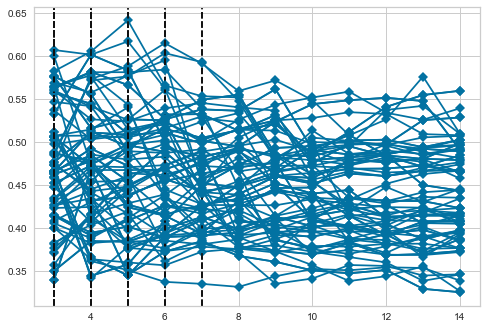

In [50]:
a=[]
column_names = ["features", "score", "elbow"]
elbow_df = pd.DataFrame(columns = column_names)

from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer

j = 1
for i in output_list:
    df1 = big_data[[i[1], i[2], i[3]]]
    x = df1.values  # returns a numpy array
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)

    model = KMeans(random_state=0)
    
    visualizer = KElbowVisualizer(model, k=(3,15), metric='silhouette', timings=False)
    visualizer.fit(x_scaled)
    score = visualizer.elbow_score_
    value = visualizer.elbow_value_

    if score>0.55:
        # visualizer.show()
        idx = df1.columns
        mylist = idx.tolist()

        new_df = pd.DataFrame(columns = column_names)

        new_df['features'] = [mylist]
        new_df['score'] = score
        new_df['elbow'] = value

        elbow_df = pd.concat([elbow_df, new_df], ignore_index=True)

        print("Iteration: ", j, " out of: ", len(output_list))
        
    j += 1


elbow_df = elbow_df.sort_values('elbow', ascending=False)
elbow_df = elbow_df.sort_values('score', ascending=False, ignore_index=True)
elbow_df.to_csv('elbow_clusters.csv', index=False)

In [172]:
'''
PCA
'''
X = big_data.values
y = labels

pca = PCA(n_components=2, svd_solver='full')
X_r = pca.fit_transform(X)

scatter2d(X_r, labels, [0, 1])

In [173]:
#  mixed results, very linear

# '''
# Clustering of PCA using K-means

# X = [Country, Time, Features]
# Plot the clusters against properties
# '''
# X = X_r
# kmeans = KMeans(n_clusters=6).fit(X)
# # plt.scatter(X[:, 0], X[:, 1], c= kmeans.labels_)
# scatter2d(X, kmeans.labels_, [0, 1])

In [174]:
#  not working well


# ''' 
# Clustering of PCA using DBSCAN
# '''
# X = X_r
# dbs = DBSCAN(eps=600, min_samples=4).fit(X)
# scatter2d(X, dbs.labels_, [0, 1])

In [180]:
'''
t-SNE
'''
X = big_data.values
y = labels
tsne = TSNE(perplexity=30, n_components=2, learning_rate='auto', metric ='euclidean', random_state=0, n_jobs=-1)
X_embedded = tsne.fit_transform(X)
scatter2d(X_embedded, labels, [0, 1])

In [185]:
# '''
# Clustering of t-SNE using K-means

# X = [Country, Time, Features]
# Plot the clusters against properties
# '''
# X = X_embedded
# kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
# # plt.scatter(X[:, 0], X[:, 1], c= kmeans.labels_)
# scatter2d(X, kmeans.labels_, [0, 1])

'''
Clustering of t-SNE using DBSCAN
'''
X = X_embedded
dbs = DBSCAN(eps=2, n_jobs=-1).fit(X)
scatter2d(X, dbs.labels_, [0, 1])

In [178]:
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

# def create_tsne_plots(X, y, dist_metrics):
X = big_data.values
dist_metrics = [
    "braycurtis",
    "canberra",
    "chebyshev",
    "cityblock",
    "correlation",
    "cosine",
    # "dice", dots (?)
    "euclidean",
    # "hamming", sparse layout
    # "jaccard", dots (?)
    # "jensenshannon", not valid
    # "kulsinski", dots (?)
    # "kulczynski1", not valid
    # "mahalanobis", required additional arg
    # "matching", dots 
    "minkowski",
    # "rogerstanimoto", dots 
    # "russellrao", dots
    # "seuclidean", init error?
    # "sokalmichener", dots
    # "sokalsneath", dots
    "sqeuclidean",
    # "yule"  dots
    ]

final_fig = sp.make_subplots(rows=3, cols=3,
    subplot_titles=dist_metrics)

for i in range(0, len(dist_metrics)):
    
    row_i = int(i/3) + 1
    col_i = i % 3 + 1

    tsne = TSNE(
        perplexity=30, n_components=2, learning_rate='auto',
        init='random', metric=dist_metrics[i], random_state=0, n_jobs=-1)
    X_embedded = tsne.fit_transform(X)

    fig = px.scatter(X_embedded, x=X_embedded[:,0], y=X_embedded[:,1], color=y)

    if i != 0:
        for j in range(0, len(countries)):
            fig['data'][j]['showlegend'] = False

    fig_traces = []
    for trace in range(len(fig["data"])):
        fig_traces.append(fig["data"][trace])

    for traces in fig_traces:
        final_fig.append_trace(traces, row=row_i, col=col_i)

final_fig.update_layout(height=1000, title_text="t-SNE Subplots")
final_fig.show()